## Fuentes:

Comenzar por youtube...

https://www.youtube.com/watch?v=9zhrxE5PQgY

https://www.youtube.com/watch?v=l4X-kZjl1gs

Seguir por la teoria:

http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/

http://arunmallya.github.io/writeups/nn/lstm/index.html#/2

Y terminamos en el codigo:

http://colah.github.io/posts/2015-08-Understanding-LSTMs/

https://github.com/nicholaslocascio/bcs-lstm

https://towardsdatascience.com/lstm-by-example-using-tensorflow-feb0c1968537

# Empecemos...

Primero en todo script de python comenzamos por los import, que es como un include en C, le decimos al interprete donde encontrar las librerias y como las llamamos.

En este caso, por ser un Jupyter Notebook, le damos dos ordenes distintas al resto, que son %reset y %matplotlib inline. Estas instrucciones son para resetear las variables (en caso de querer volver a ejecutar) y de graficar sobre el mismo notebook, respectivamente.

In [1]:
%reset
%matplotlib inline

# Importamos tensoflow y le asignamos el nombre "tf"
import tensorflow as tf
# Importamos numpy (libreria de calculo) y le asignamos el nombre "np"
import numpy as np
# Importamos unicodecsv (libreria de lectura de csv que soporta utf-8, osea acentos) y le asignamos el nombre "csv"
import unicodecsv as csv
# Importamos matplotlib (libreria para hacer plots como matlab) y le asignamos el nombre "plt"
import matplotlib.pyplot as plt
# Más imports...
import collections
import random
import time


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Definición de Parametros 

Para que sea más prolijo todas las definiciones las ponemos acá. Pueden declararse donde sea las variables, pero estos van a ser las perillas que nosotros vamos a querer ajustar generalemente.

In [2]:
# Unidades internas de mis celdas LTMS
LTMS_internal_units_1 = 512
LTMS_internal_units_2 = 512

# Parametro de velocidad de aprendizaje
velocidad_aprendizaje = 0.001

# Iteraciones a realizar
iteraciones_entrenamiento = 300000
# Tamaño de minibatch
tam_minibatch = 10
# Cada cuanto vamos a escribir información en pantalla
mostrar_info_cada = 5000
# Cada cuanto vamos a escribir información en el tensorboard
procesar_info_cada = 100

# Este es el fulano al cual queremos inmitar
ARCH_TWEETS = "elonmusk_tweets.csv"

# Palabras de entrada a la red. Este parametro está para que sea facil de interpretar todo, 
# pero veremos que no hace falta...
palabras_entrada = 3
# Otra utilidad adicional, totalmente vacía de justificación, 
# es ponerlo en cero para calcularlo despues con el diccionario

# Este parametro es importante, va a definir cuantas veces se debe repetir una palabra 
# en mi base datos original para que sea utilizada en el diccionario final.
# El problema es simple, si alguién alguna vez se encontró tan sorprendido por algo que tuvo que decir
# "Fué un momento inefable"
# La probabilidad que aprendamos a utilizar la palabra "inefable" sin aprender de memoria la frace anterior
# es realmente baja... Así como sucede con esa palabra sucede con muchas más, lo que hace que nuestra salida
# tenga una dimención muy grande y contemos con poca información para generalizar sus usos. 
# Por lo que nos conviene quitarlo del medio...
min_repeticiones = 5

# Solo para el test...
MODELO_RESTORE= "./Salidas/elonmusk_tweets_Final_bot.ckpt"

## Funciones

Acá declaramos todas las funciones que vallamos a utilizar. No es necesario que esten acá, pueden declararse en cualquier momento ANTES de ser utilizadas. Pueden ir a archivos aparte también y ser importadas.

In [3]:
# Función para armar un diccionario directo (Palabra -> Codigo) e inverso (Codigo -> Palabra) a partir de una lista

def build_dataset(words):
    count = collections.Counter(words).most_common()
    dictionary = dict()
    for word, _ in count:
        dictionary[word.decode("utf-8")] = len(dictionary)
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
    return dictionary, reverse_dictionary

# Función para hacer un histograma de las palabras incluidas en los tweets

def histograma_diccionario(palabras, diccionario, min_repeticiones_plot = 0, PLOT = False):
    # Saco el tamaño del vocabulario
    tam_vocabulario = len(diccionario)
    # Reservo memoria con un bin por palabra
    bines = np.zeros(tam_vocabulario)
    # Recorro todas las palabras y sumo un poroto cada vez que encuentro una repetición.
    for i in range(0,len(palabras)):
        # Busco el código de la palabra en el diccionario y sumo poroto ahí.
        bines[diccionario[ palabras[i].decode("utf-8")]] += 1
        
    # Si se indica se plotea el histograma, para hacerlo más interpretable se pueden plotear solo aquellos bines
    # con min_repeticiones_plot repeticiones. 
    # El histograma esta ordenado de mayor a menor, esa es la mágia de la función "dict"
    if PLOT:
        plt.bar(range(0,len(bines[bines>min_repeticiones_plot])), bines[bines>min_repeticiones_plot], color='g')
        plt.show()

    return bines

# Funciones para TensorFlow. 

# Declaran pesos y biases y los inicializan con una desitribución dada.
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Función que calcula mucha info de las variables para TensoBoard
def variable_summaries(var):
  #"""Attach a lot of summaries to a Tensor (for TensorBoard visualization)."""
  with tf.name_scope('summaries'):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

## Construcción de entrada

### Lectura del archivo de tweets

Palabras únicas dentro del vocabulario: 5530
Palabras totales dentro de la base de datos: 32916


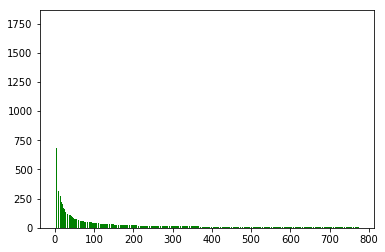

In [4]:
# Lista vacia donde voy a meter los tweets
palabras = list()
# Abro el archivo para leerlo
with open(ARCH_TWEETS, 'rb') as csvfile:
    # Leo usando la funcion de lectura de csv
    spamreader = csv.reader(csvfile, encoding='utf-8', delimiter=',')
    # Una vez leido quiero separalo en palabras, así que empiezo por separalo en lineas (o tweets)
    for row in spamreader:
        # Y a cada linea la separo en palabras
        for palabra in row:
            palabras.append(palabra.encode('utf-8'))

# Convierto la linea en un array de numpy
palabras = np.asarray(palabras)
# Y lo transformo a un vector
palabras = np.reshape(palabras, [-1, ])

# Armo el diccionario directo e inverso
diccionario, diccionario_inverso = build_dataset(palabras)

# Saco info y la imprimo
tam_vocabulario = len(diccionario)
cant_palabras = len(palabras)
print('Palabras únicas dentro del vocabulario: %d'%tam_vocabulario)
print('Palabras totales dentro de la base de datos: %d'%cant_palabras)

# Ploteo el histograma
bines = histograma_diccionario(palabras, diccionario, min_repeticiones, PLOT = True)


Palabras únicas dentro del vocabulario común: 573
Palabras totales dentro de la base de datos final: 3641


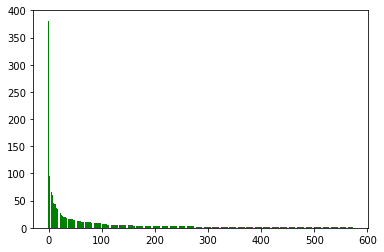

In [5]:
# Defino cual es la palabra limite a conservar
# Recordado que el diccionario ordena por repetición, cualquier paralabra con código superior
# a la palabra con el límite de repeticiones tendrá menos repeticiones.
bines_aux = bines[bines>min_repeticiones]
limit_palabra = len(bines_aux)

# Volvemos a cargar el archivo pero ahora vamos a recortar las oraciones con
# menos palabras que las elegidas

# Lista auxiliar que conserva el largo de oraciones
largo_oraciones = list()
# Lista con las palabras con la cantidad de repeticiones deseadas
palabras_comunes = list()
# Abro el archivo
with open(ARCH_TWEETS, 'rb') as csvfile:
    # Leo el CSV nuevamente
    spamreader = csv.reader(csvfile, encoding='utf-8', delimiter=',')
    # Analizo cada linea o tweet
    for row in spamreader:
        # Lista vacia para contener las distintas oraciones dentro del tweet
        row_of_rows = list()
        # Analizo si hay un punto, si lo hay es que hay mas de una oración en el tweet
        if '.' in row:
            # Si hay punto busco donde esta
            puntos_enc = 0
            for palabra in row:
                if '.' in palabra:
                    puntos_enc += 1
            # Por cada punto hago una enntrada en row_of_rows, separando el tweet en oraciones
            palabra_idx = -1
            for i in range(0,puntos_enc):
                row_aux = list()
                while True:
                    palabra_idx += 1
                    row_aux.append(row[palabra_idx])
                    if '.' in row[palabra_idx]:
                        break
                row_of_rows.append(row_aux)

        # Si no hay puntos, copio la unica oracion del tweet a row_of_rows
        else:
            row_of_rows.append(row)

        # Ahora analizo cada oracion dentro de row_of_rows
        for row_crop in row_of_rows:
            # Si es una linea vacia la descarto (por las dudas esta esto)
            if len(row_crop) == 0:
                continue
            # Agrego el largo de la oración a la lista
            largo_oraciones.append(len(row_crop))
            # Checkeo si la oración contiene solo palabras con más repeticiones de las pedidas
            copiar = True
            for palabra in row_crop:
                # Si la codificación es mayor al limite, es una palabra con pocas repeticiones
                if diccionario[ palabra] > limit_palabra:
                    copiar = False
            # Si todas las palabras de la oración cumplen, entonces copio la oración a la base de datos final
            if copiar:
                for palabra in row_crop:        
                    palabras_comunes.append(palabra.encode('utf-8'))

# Paso nuevamente a numpy y transformo en vector
palabras_comunes = np.asarray(palabras_comunes)
palabras_comunes = np.reshape(palabras_comunes, [-1, ])

# Genero un nuevo diccionario que solo contiene palabras "comunes"
diccionario_comun, diccionario_inverso_comun = build_dataset(palabras_comunes)

# Saco info y la imprimo
tam_vocabulario_comun = len(diccionario_comun)
cant_palabras_comunes = len(palabras_comunes)
print('Palabras únicas dentro del vocabulario común: %d'%tam_vocabulario_comun)
print('Palabras totales dentro de la base de datos final: %d'%cant_palabras_comunes)

# Ploteo el histograma
bines_comunes = bines = histograma_diccionario(palabras_comunes, diccionario_comun, 0, PLOT = True)



In [6]:
# Finalmente si seleccione 0 palabras de entrada calculo la cantidad de palabras de entrada 
# como la media de palabras por oración
if palabras_entrada == 0:
    palabras_entrada = round((np.array(largo_oraciones).mean()/2))
    palabras_entrada = int(palabras_entrada)

## Construcción Grafo TensorFlow

En tesorflow la idea es primero armar un mapa de operaciones a realizar que se llama grafo. Este grafo esta compuesto por nodos que son operaciones y lineas que son tensores. Los tensores son matrices N dimencionales que llevan los datos. Una particularidad de tensorflow es que podemos definir tensores con una de sus dimenciones desconocidas, la cual se calcula en tiempo de ejecución. Un ejemplo de esto es el tamaño de batch. El batch es la cantidad de ejemplos que le damos a la red antes de actualizar sus pesos, este numero no tiene importancia para los cálculos de las derivadas del grafo, pero si a la hora de ejecutarlo.

### Red

In [7]:
# Primero declaramos el punto de entrada.
# La entrada es un tensor de tipo "contenedor". Es un tipo de dato que va a ser
# cargado con los datos de entrada que le proveamos.
# Tiene 3 dimenciones [batch_size , palabras_entrada , Caracteristicas]
# El tamaño del bach no lo definimos aún, porque no es necesario, entonces le ponemos None
# Si bien conocemos la cantidad de palabras de entrada que vamos a utilizar, elejimos ponerle 
# None. Esto es para mostrar la flexibilidad de las redes recursivas, como la celda se aplica
# sobre cadad entrada pero tiene los pesos son compartidos. Es como si en realidad existiera solo 
# una celda que se aplica recursivamente (que casualidad que se llamen recursivas).
x = tf.placeholder("float", [None, None, 1])

# El objetivo también es un contenedor donde vamos a poner el... objetivo...
y = tf.placeholder("float", [None, tam_vocabulario_comun])

# Ahora declaro las celdas LSTM.
# Los tf.name_scope son para poder darles un nombre y poder visualizarlas mejor en tensorboard
with tf.name_scope('multi_LTSM'):    
    with tf.name_scope('LTSM_1'):
        lstm_cell_1 = tf.nn.rnn_cell.LSTMCell(num_units=LTMS_internal_units_1, state_is_tuple=True)

    with tf.name_scope('LTSM_2'):
        lstm_cell_2 = tf.nn.rnn_cell.LSTMCell(num_units=LTMS_internal_units_2, state_is_tuple=True)

    # Una vez declaradas las dos celdas con sus respectivos elementos las conectamos de manera que
    # la salida de la primer celda sea la entrada de la segunda. Por suerte TF hace esto por nosotros.
    multi_lstm_cells = tf.contrib.rnn.MultiRNNCell(cells=[lstm_cell_1, lstm_cell_2] , state_is_tuple=True)

# Ahora debemos indicarle a tensorflow que estas celdas son parte de una red recursiva. Esto se hace con 
# "tf.nn.static_rnn" o "tf.nn.dynamic_rnn". Estas funciones hacen casi lo mismo, solo que mientras la 
# ultima configura la red con un lazo (un while) la otra la "hardcodea". No hay diferencia en la velocidad
# de ejecución y es posible que la estática sea descontinuada en el futuro, ya que es una verción de la 
# dinamica donde siempre el numero de itraciones es el mismo.
with tf.name_scope('Dyn_RNN'):
    output_rnn, state_rnn = tf.nn.dynamic_rnn(multi_lstm_cells, x, dtype=tf.float32)    
    # output_rnn es la salida a cada t de la celda, con tamaño [batch_size, max_time, cell.output_size]
    # state_rnn es el ultimo estado (t = T) de cada uno de los layers de celdas [num_celdas, batch_size, cell.state_size]

# La salida que queremos nos la da state_rnn
outputs = state_rnn
# Más especificamente el estado de la última celda
outputs = outputs[1]   

# Luego de definir la celda dinamica se definen los tamaños de las matrices de pesos y bias
# así que podemos setear los cálculos para el tensorboard.
with tf.name_scope('multi_LTSM'):    
    with tf.name_scope('LTSM_1'):
        with tf.name_scope('Weights'):
            variable_summaries(lstm_cell_1.weights[0])
        with tf.name_scope('Bias'):
            variable_summaries(lstm_cell_1.weights[1])
    with tf.name_scope('LTSM_2'):
        with tf.name_scope('Weights'):
            variable_summaries(lstm_cell_2.weights[0])
        with tf.name_scope('Bias'):
            variable_summaries(lstm_cell_2.weights[1])

# Ahora debemos interpretar el estado interno que nos dan las celdas como una palabra del diccionario.
# Esto lo hacemos con una simple multiplicación de matrices optimizable o, si quieren sonar más pro, un 
# soft-maxed fully-connected layer (con esto matás en un boliche).
# Primero declaramos los pesos y bias:
with tf.name_scope('Matrix_Mult'):
    with tf.name_scope('pesos_salida'):
        weights = weight_variable([LTMS_internal_units_2, tam_vocabulario_comun]) 
        variable_summaries(weights)
    with tf.name_scope('biases_salida'):
        biases = bias_variable([tam_vocabulario_comun])
        variable_summaries(biases)
    
    # Multiplicamos las matrices
    out_tensor = tf.matmul(outputs[-1], weights) + biases
    # Soft-max para todos y todos
    soft_max_out_tensor = tf.nn.softmax(out_tensor)
    

### Costo y optimización

Aparte de describir la red debemos describir como es nuestra función de costo y como queremos optimizarla. Recordemos que la función de costo es la manera de decirle al optimizador que es lo que consideramos que esta bien o mal. En nuestro caso el costo es tratar de disminuir la diferencia entre la probabilidad de que a palabra que siga es la que propone la red y la realidad.

In [8]:
with tf.name_scope('cost'):
# Acá definimos el costo, para más info https://en.wikipedia.org/wiki/Cross_entropy
#   cost = tf.reduce_mean(-tf.reduce_sum(soft_max_out_tensor * tf.log(y), reduction_indices=[1]))
# MUCHO MUY IMPORTANTE:
# Como esto es un ejemplo se dividió el calculo del costo entre el soft-masx y la cross-entropy. 
# Esto no es recomendable por eso TF no nos provee un tf.nn.cross_entropy, sino que nos provee
# una función que lo hace todo "tf.nn.softmax_cross_entropy_with_logits". Esta función es más
# estable numericamente y está optimizada, de querer usarla es así:
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=out_tensor, labels=y))
# "with_logits" quiere decir que el vector de entrada no necesariamente suma 1.
    tf.summary.scalar('cost', cost)

# ¿Porque no usar la que escribimos? porque en el caso de que una palabra tenga probabilidad 
# cero de ser la corecta (algo que pasa con todas las palabras menos la correcta), la operacion
# tf.log(y) --> -inf. Esto es un problema grave...

# Una vez definido el costo definimos la función de optimización:
#optimizer = tf.train.RMSPropOptimizer(learning_rate=velocidad_aprendizaje).minimize(cost)
optimizer = tf.train.AdamOptimizer(learning_rate=velocidad_aprendizaje).minimize(cost)


Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



### Cálculos auxiliares

A veces es conveniente tener cálculos que nos muestren información que es útil par el humano pero que no tiene razon de ser para la optimización. Estos cálculos también deben ser declarados dentro del grafo.
Tambien, y muy importante, se define como se va a guardar la información de la red entrenada.

In [9]:
# Para saber cuantas palabras predecimos correctamente
with tf.name_scope('accuracy'):
    correct_pred = tf.equal(tf.argmax(soft_max_out_tensor,1), tf.argmax(y,1))
    
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.summary.scalar('accuracy', accuracy)


# Declaramos la operación para guardar todo
saver = tf.train.Saver()

# Operación de inicialización de variables
init = tf.global_variables_initializer()

### Inicialización

Una vez todo definido se inicia la sessión de tensorflow, donde se construye el grafo. El tipo de sesión es "interactiva" lo que deja los recursos tomados por TF incluso despues del entrenamiento (útil para testear resultados).
También aquí se incluyen las operaciones necesarias para que tensorboard nos dibuje el grafo y nos calcule la info sobre las variables. 

In [10]:
# Activamos la sesión
session = tf.InteractiveSession()

# Inicializamos el grafo
session.run(init)

# Declaramos la salida del tensorboard y construimos la visualización
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter('Tensorboard_out' + '/test',session.graph)
train_writer.add_graph(session.graph)


# Break Teorico...

## ¿como estan armados los tensores en tensorflow?

La LSTM tiene 4 gates. La LTMS tiene un solo peso cuando esta en soledad, tiene un solo estado oculto. Cuando seteamos las unidades internas estamos agregando unidades que funcionan en paralelo y que se comunican a traves del estado oculto. El estado oculto (C en la bibliografia) tiene dimención la cantdad de unidades que existen. La salida h tambien tiene dimencion igual al total de unidades en paralelo.
Cada gate debe actualizar que se recuerda y cada unidad lo hace para ella sola, pero teniendo en cuenta la información de todas. Es decir que si nuestra entrada tiene N elementos y ponemos D celdas LTMS, cada gate debe tener N+D pesos y D biases para poder tener en cuenta toda la información. Asi que seria un vector de 1 x (N+D) pesos por cada gate de cada celda. Entonces:

Pesos del Gate * Vector concatenado de entrada + bias = decicion del gate para el estado oculto de esta celda (antes de la alinealidad)

$\begin{pmatrix}W^{x}_1 & W^{x}_2 & W^{x}_3 & ... & ... & W^{x}_{N+D} \end{pmatrix} *  \begin{pmatrix}X_1 \\X_2 \\X_3 \\... \\... \\X_{N} \\h^{t-1}_1 \\h^{t-1}_2 \\h^{t-1}_3 \\... \\... \\h^{t-1}_{D} \end{pmatrix}  +  b^{x}_1 = G^{x}_1$

Pero como esto se hace en cada estado oculto y tenemos tantos estados ocultos como celdas ( D ):


$\begin{pmatrix}W^{x}_{1,1} & W^{x}_{1,2} & W^{x}_{1,3} & ... & ... & ... & ... & W^{x}_{1,D} \\W^{x}_{2,1} & W^{x}_{2,2} & W^{x}_{2,3} & ... & ... & ... & ... & ... \\W^{x}_{3,1} & W^{x}_{3,2} & W^{x}_{3,3} & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\W^{x}_{D,1} & ... & ... & ... & ... & ... & ... & W^{x}_{D,N+D} \\\end{pmatrix} * \begin{pmatrix}X_1 \\X_2  \\... \\X_{N} \\h^{t-1}_1 \\h^{t-1}_2  \\... \\h^{t-1}_{D} \end{pmatrix}+\begin{pmatrix}b^{x}_1 \\b^{x}_2  \\... \\... \\... \\...  \\... \\b^{x}_{D} \end{pmatrix}= \begin{pmatrix}G^{x}_1 \\G^{x}_2  \\... \\... \\... \\...  \\... \\G^{x}_{D} \end{pmatrix}$


Y ademas tenemos 4 gates! El "output gate" (o), el "forget gate" (f) y "input gate" (i) que funciona junto con el otro gate que no encontre el nombre oficial ($\widetilde{C}$, viene a ser como un estado interno).  En total cada aplicacion de las D celdas LTSM es una multiplicacion de matrices del siguiente tamaño $ [4xD  , (N+D)] * [(N+D) , 4xD] + [4xD , 1] = [4xD , 1] $. Distribuido asi:

$\begin{pmatrix}W_{1,1}^{o} & W_{1,2}^{o} & W_{1,3}^{o} & ... & ... & ... & ... & W_{1,D}^{o} \\W_{2,1}^{o} & W_{2,2}^{o} & W_{2,3}^{o} & ... & ... & ... & ... & ... \\W_{3,1}^{o} & W_{3,2}^{o} & W_{3,3}^{o} & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\W_{D,1}^{o} & ... & ... & ... & ... & ... & ... & W_{D,N+D}^{o} \\W_{1,1}^{i} & W_{1,2}^{i} & W_{1,3}^{i} & ... & ... & ... & ... & W_{1,D}^{i} \\W_{2,1}^{i} & W_{2,2}^{i} & W_{2,3}^{i} & ... & ... & ... & ... & ... \\W_{3,1}^{i} & W_{3,2}^{i} & W_{3,3}^{i} & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\W_{D,1}^{i} & ... & ... & ... & ... & ... & ... & W_{D,N+D}^{i} \\W_{1,1}^{\widetilde{C}} & W_{1,2}^{\widetilde{C}} & W_{1,3}^{\widetilde{C}} & ... & ... & ... & ... & W_{1,D}^{\widetilde{C}} \\W_{2,1}^{\widetilde{C}} & W_{2,2}^{\widetilde{C}} & W_{2,3}^{\widetilde{C}} & ... & ... & ... & ... & ... \\W_{3,1}^{\widetilde{C}} & W_{3,2}^{\widetilde{C}} & W_{3,3}^{\widetilde{C}} & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\W_{D,1}^{\widetilde{C}} & ... & ... & ... & ... & ... & ... & W_{D,N+D}^{\widetilde{C}} \\W_{1,1}^{f} & W_{1,2}^{f} & W_{1,3}^{f} & ... & ... & ... & ... & W_{1,D}^{f} \\W_{2,1}^{f} & W_{2,2}^{f} & W_{2,3}^{f} & ... & ... & ... & ... & ... \\W_{3,1}^{f} & W_{3,2}^{f} & W_{3,3}^{f} & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\... & ... & ... & ... & ... & ... & ... & ... \\W_{D,1}^{f} & ... & ... & ... & ... & ... & ... & W_{D,N+D}^{f} \\\end{pmatrix}*\begin{pmatrix}X_1 \\X_2  \\... \\X_{N} \\h^{t-1}_1 \\h^{t-1}_2  \\... \\h^{t-1}_{D} \end{pmatrix}+\begin{pmatrix}b^{o}_1\\b^{o}_2 \\... \\... \\... \\... \\... \\b^{o}_D \\b^{i}_1\\b^{i}_2 \\... \\... \\... \\... \\... \\b^{i}_D \\b^{\widetilde{C}}_1\\b^{\widetilde{C}}_2 \\... \\... \\... \\... \\... \\b^{\widetilde{C}}_D \\b^{f}_1\\b^{f}_2 \\... \\... \\... \\... \\... \\b^{f}_D \\\end{pmatrix}=\begin{pmatrix}G^{o}_1\\G^{o}_2 \\... \\... \\... \\... \\... \\G^{o}_D \\G^{i}_1\\G^{i}_2 \\... \\... \\... \\... \\... \\G^{i}_D \\G^{\widetilde{C}}_1\\G^{\widetilde{C}}_2 \\... \\... \\... \\... \\... \\G^{\widetilde{C}}_D \\G^{f}_1\\G^{f}_2 \\... \\... \\... \\... \\... \\G^{f}_D \\\end{pmatrix}$




He aquí lo que vemos cuando nos metemos en el kernel de la RNN utilizando el tensor board.


## ¿como estan armados los grafos de las celdas en tensorflow?

Esta es mas dificil... No vas a ver las celdas LSTM una al lado de la otra en el tensorboard, sino que vas a ver un loop que genera automaticamente la cantidad de celdas necesarias dependiendo del largo del input. Mas info en:

http://www.wildml.com/2016/08/rnns-in-tensorflow-a-practical-guide-and-undocumented-features/

## ¿como se entrena todo esto?

Aunque sea muy grande, todo la celda (y el conjunto de celdas) es derivable y se puede usar desde backpropagation through time (Que es backpropagation normal solo que saben que cada estado depende del anterior por medio de $h_{t-1}$) hasta cosas mas complicadas como ADAM. Gacias a dios para esto existe tensorflow, podriamos derivar el backpropagation para una celda, pero no seria tan eficiente y tomaría mucho mas tiempo. Queda de tarea para el hogar...

# Entrenamiento

In [11]:
# Nos quedamos con el timestap de inicio para medir tiempo
start_time = time.time()

# Inicializamos variables
step = 0
offset = random.randint(0,palabras_entrada+1)
end_offset = palabras_entrada + 1
acc_total = 0
loss_total = 0

print("Starting optmization...")
# Mientras queramos...
while step < iteraciones_entrenamiento:

    symbols_in_keys = np.zeros((tam_minibatch,palabras_entrada,1))
    symbols_out_onehot = np.zeros((tam_minibatch,tam_vocabulario_comun))
    for i_batch in range(0,tam_minibatch):

        # Generamos un minibatch empezando de un punto al azar
        if offset > (len(palabras_comunes)-end_offset):
            # En caso de haberle dado una vuelta completa a nuestra base de datos, comenzamos nuevamente
            offset = random.randint(0, palabras_entrada+1)

        # Copiamos de la base de datos la cantidad de palabras elegidas a un vector codificado
        symbols_in_keys_aux = [ [diccionario_comun[ palabras_comunes[i].decode("utf-8")]] for i in range(offset, offset+palabras_entrada) ]
        # Lo transformamos en un batch con la forma del tensor de entrada
        symbols_in_keys_aux = np.reshape(np.array(symbols_in_keys_aux), [-1, palabras_entrada, 1])
        symbols_in_keys[i_batch, : , :] = symbols_in_keys_aux

        # Para la salida (verdad objetivo) armamos un vector lleno de ceros
        symbols_out_onehot_aux = np.zeros([tam_vocabulario_comun], dtype=float)
        # Y al código de la palabra que sigue a las alimentadas a la red, le asignamos 1 (100% de probabilidad)
        symbols_out_onehot_aux[diccionario_comun[palabras_comunes[offset+palabras_entrada].decode("utf-8")]] = 1.0
        # Y lo transformamos en la dimensiín del placeholder de salida
        symbols_out_onehot_aux = np.reshape(symbols_out_onehot_aux,[1,-1])
        symbols_out_onehot[i_batch, :] = symbols_out_onehot_aux;

    # Corremos los cálculos:
    # --- optimizar (optimización de la red)
    # --- accuracy (medición para mostrar)
    # --- cost (valor de la función de costos para el estado actual)
    # --- soft_max_out_tensor (valor de la salida de la red para el último paso)
    # --- merged (calculo de información sobre variables a optimizar - TensorBoard)
    # Y le pasamos como entrada a los placeholders que definimos:
    # --- symbols_in_keys
    # --- symbols_out_onehot
    _, acc, loss, onehot_pred, summary = session.run([optimizer, accuracy, cost, soft_max_out_tensor, merged], \
                                            feed_dict={x: symbols_in_keys, y: symbols_out_onehot})
    # Agrego la info al tensorboard si corresponde
    if (step+1) % procesar_info_cada == 0:
        train_writer.add_summary(summary, step)
    # Vamos sumando el costo y la presición para hacer luego un promedio
    loss_total += loss
    acc_total += acc
    # Y checkeamos si es el paso en el que vamos a mostrar todo
    if (step+1) % mostrar_info_cada == 0:
        # De ser así imprimimos la info
        print("Iter= " + str(step+1) + ", Costo Promedio = " + \
              "{:.6f}".format(loss_total/mostrar_info_cada) + ", Presición promedio= " + \
              "{:.2f}%".format(100*acc_total/mostrar_info_cada))
        # Reseteamos promediadores
        acc_total = 0
        loss_total = 0
        # Recuperamos las palabras usadas en el bach
        symbols_in = [palabras_comunes[i].decode("utf-8") for i in range(offset, offset + palabras_entrada)]
        symbols_out = palabras_comunes[offset + palabras_entrada].decode("utf-8")
        # Las transformamos de codigo en palabras 
        symbols_out_pred = diccionario_inverso_comun[int(tf.argmax(np.reshape(onehot_pred[0],[1,-1]), 1).eval())]
        # Mostramos la última predicción
        print("%s - [%s] vs [%s]" % (symbols_in,symbols_out,symbols_out_pred))
        
        # Guardamos el paso intermedio
        saver.save(session, "./Salidas/%s_%d_bot.ckpt"%(ARCH_TWEETS.rpartition('.')[0],step+1))
    # Update del contador de pasos
    step += 1
    # Nos corremos en el indice de entrada de palabrasm una palabra para adelante
    offset += (palabras_entrada+1)
# Termino!
print("¡Optimización finalizada!")
print("Tiempo transcurrido: ", time.time() - start_time)

# Guardamos iteración final
MODELO_RESTORE = "./Salidas/elonmusk_tweets_Final_bot.ckpt"
save_path = saver.save(session, MODELO_RESTORE)
print("Modelo final guardado en archivo: %s" % save_path)


Starting optmization...
Iter= 5000, Costo Promedio = 5.380822, Presición promedio= 10.46%
['ordered', 'for', 'almost'] - [any] vs [.]
Iter= 10000, Costo Promedio = 4.334070, Presición promedio= 10.14%
['a', 'great', 'idea'] - [.] vs [priority]
Iter= 15000, Costo Promedio = 3.044814, Presición promedio= 17.32%
['yes', '.', 'yes'] - [roof] vs [roof]
Iter= 20000, Costo Promedio = 3.934977, Presición promedio= 16.22%
['be', '.', 'worth'] - [seeing] vs [.]
Iter= 25000, Costo Promedio = 4.355605, Presición promedio= 12.98%
['.', 'know', 'why'] - [,] vs [.]
Iter= 30000, Costo Promedio = 3.173082, Presición promedio= 20.70%
['sure', 'actually', 'works'] - [best] vs [ui]
Iter= 35000, Costo Promedio = 3.805643, Presición promedio= 17.20%
['of', 'course', '.'] - [history] vs [it]
Iter= 40000, Costo Promedio = 2.834127, Presición promedio= 27.28%
['be', ',', 'but'] - [yes] vs [yes]
Iter= 45000, Costo Promedio = 3.206004, Presición promedio= 24.10%
['release', 'rolling', 'out'] - [next] vs [.]
Iter

KeyboardInterrupt: 

# Producción

Ahora podemos cargar el modelo ya entrenado y ver que tiene para decir.
No es necesario cargar si acabamos de entrenar, pero está buena la práctica.

In [14]:
# Para alarar, esto lo podes correr sin haber ejecutado el entrenamiento, pero si tenes que 
# ejecutar todo el codigo que arma el grafo. Lo que se guarda son solo las variables.
saver.restore(session, MODELO_RESTORE)

print("Restaurado modelo: %s"%MODELO_RESTORE)


INFO:tensorflow:Restoring parameters from ./Salidas/elonmusk_tweets_Final_bot.ckpt
Restaurado modelo: ./Salidas/elonmusk_tweets_Final_bot.ckpt


In [15]:
PALABRAS_A_GENERAR = 9

while True:
    prompt = "%s words: " % palabras_entrada
    sentence = input(prompt)
    sentence = sentence.strip()
    words = sentence.split(' ')
    if len(words) != palabras_entrada:
        continue

    symbols_in_keys = [diccionario_comun[str(words[i])] for i in range(len(words))]
    for i in range(PALABRAS_A_GENERAR):
        keys = np.reshape(np.array(symbols_in_keys), [-1, palabras_entrada, 1])
        onehot_pred = session.run(soft_max_out_tensor, feed_dict={x: 
                                                                  keys})
        onehot_pred_index = int(tf.argmax(onehot_pred, 1).eval())
        sentence = "%s %s" % (sentence,diccionario_inverso_comun[onehot_pred_index])
        symbols_in_keys = symbols_in_keys[1:]
        symbols_in_keys.append(onehot_pred_index)
    print(sentence)


3 words: tesla is great
tesla is great motors less . am safety . am safety .


KeyboardInterrupt: 